# 1. PHẦN MÔ HÌNH K- TRUNG BÌNH (K-MEANS MODEL)


## 1.1. Xây dựng chương trình từ numpy

### Ví dụ 1.

In [171]:
# Gọi các thư viện cần thiết
# Ta tự xây dựng phần k-means nên sẽ không gọi sklearn
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(11)
# Kỳ vọng và hiệp phương sai của 3 cụm dữ liệu
means = [[2, 2], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]
# Số điểm mỗi cụm dữ liệu
N = 500
# Tạo các cụm dữ liệu qua phân bố chuẩn (Gaussian)
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)
# Tổng hợp dữ liệu từ các cụm
X = np.concatenate((X0, X1, X2), axis = 0)
# Số cụm = 3
K = 3
# Gán nhãn ban đầu cho các cụm, sau đó ta test model và so sánh
original_label = np.asarray([0]*N + [1]*N + [2]*N).T

In [172]:

def kmeans_display(X, label):
    K = np.amax(label) + 1
    X0 = X[label == 0, :]
    X1 = X[label == 1, :]
    X2 = X[label == 2, :]
    plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8)
    plt.plot(X1[:, 0], X1[:, 1], 'go', markersize = 4, alpha = .8)
    plt.plot(X2[:, 0], X2[:, 1], 'rs', markersize = 4, alpha = .8)
    plt.axis('equal')
    plt.plot()
    plt.show()

In [173]:
def kmeans_init_centers(X, k):
    # randomly pick k rows of X as initial centers
    return X[np.random.choice(X.shape[0], k, replace=False)]

In [174]:
def kmeans_assign_labels(X, centers):
    # calculate pairwise distances btw data and centers
    D = cdist(X, centers)
    # return index of the closest center
    return np.argmin(D, axis = 1)

In [175]:
def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster
        Xk = X[labels == k, :]
        # take average
        centers[k,:] = np.mean(Xk, axis = 0)
    return centers

In [176]:
def has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) ==
        set([tuple(a) for a in new_centers]))

In [177]:
def kmeans(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0
    while True:
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            break
        centers.append(new_centers)
        it += 1
    return (centers, labels, it)

Centers found by our algorithm:
[[2.99084705 6.04196062]
 [1.97563391 2.01568065]
 [8.03643517 3.02468432]]


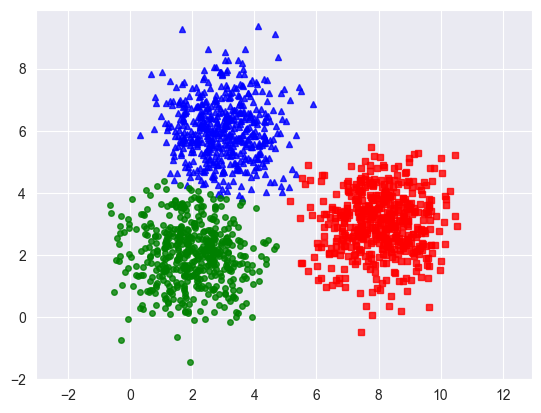

In [178]:
(centers, labels, it) = kmeans(X, K)
print('Centers found by our algorithm:')
print(centers[-1])
kmeans_display(X, labels[-1])

## 1.2. Thực hiện bằng thư viện sklearn.

Centers found by scikit-learn:
[[1.97826939 2.00223913]
 [2.98759958 6.02896527]
 [8.0410628  3.02094748]]


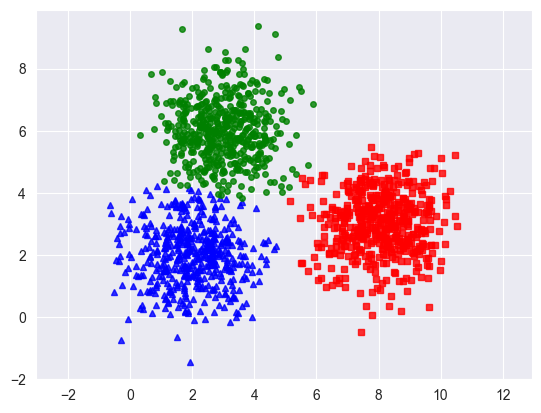

In [179]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
print('Centers found by scikit-learn:')
print(kmeans.cluster_centers_)
pred_label = kmeans.predict(X)
kmeans_display(X, pred_label)

## Ví dụ 2:

In [180]:
import numpy as np
from mnist import MNIST
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

In [181]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# This function visualizes filters in matrix A. Each column of A is a
# filter. We will reshape each column into a square image and visualizes
# on each cell of the visualization panel.
# All other parameters are optional, usually you do not need to worry
# about it.
# opt_normalize: whether we need to normalize the filter so that all of
# them can have similar contrast. Default value is true.
# opt_graycolor: whether we use gray as the heat map. Default is true.
# opt_colmajor: you can switch convention to row major for A. In that
# case, each row of A is a filter. Default value is false.

# source: https://github.com/tsaith/ufldl_tutorial
def display_network(A, m = -1, n = -1):
    opt_normalize = True
    opt_graycolor = True
    # Rescale
    A = A - np.average(A)
    # Compute rows & cols
    (row, col) = A.shape
    sz = int(np.ceil(np.sqrt(row)))
    buf = 1
    if m < 0 or n < 0:
        n = np.ceil(np.sqrt(col))
        m = np.ceil(col / n)

    image = np.ones(shape=(buf + m * (sz + buf), buf + n * (sz + buf)))
    if not opt_graycolor:
        image *= 0.1
    k = 0
    for i in range(int(m)):
        for j in range(int(n)):
            if k >= col:
                continue
            clim = np.max(np.abs(A[:, k]))
            if opt_normalize:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz +
buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / clim
            else:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / np.max(np.abs(A))
            k += 1
    return image
def display_color_network(A):
    """
    # display receptive field(s) or basis vector(s) for image patches
    #
    # A the basis, with patches as column vectors
    # In case the midpoint is not set at 0, we shift it dynamically
    :param A:
    :param file:
    :return:
    """
    if np.min(A) >= 0:
        A = A - np.mean(A)
    cols = np.round(np.sqrt(A.shape[1]))
    channel_size = A.shape[0] / 3
    dim = np.sqrt(channel_size)
    dimp = dim + 1
    rows = np.ceil(A.shape[1] / cols)
    B = A[0:channel_size, :]
    C = A[channel_size:2 * channel_size, :]
    D = A[2 * channel_size:3 * channel_size, :]
    B = B / np.max(np.abs(B))
    C = C / np.max(np.abs(C))
    D = D / np.max(np.abs(D))
# Initialization of the image
    image = np.ones(shape=(dim * rows + rows - 1, dim * cols + cols - 1, 3))
    for i in range(int(rows)):
        for j in range(int(cols)):
# This sets the patch
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 0] = B[:, i * cols
+ j].reshape(dim, dim)
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 1] = C[:, i * cols
+ j].reshape(dim, dim)
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 2] = D[:, i * cols
+ j].reshape(dim, dim)
    image = (image + 1) / 2
    return image

In [182]:
import os
import numpy as np

# set names to the paths because they're too long
data_path = '/Users/nguyencongtri/PycharmProjects/MachineLearning/Lab5/data'
# train path
train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')
# test path
test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')


def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
    """
    This shuffle param is active when .gz is downloaded at:
    - 'http://yann.lecun.com/exdb/mnist/'
    - This function return random num_images in 60000 or 10000
    """
    # read data
    import gzip # to decompress gz (zip) file
    # open file training to read training data
    f_images = gzip.open(images_path,'r')

    # skip 16 first bytes because these are not data, only header infor
    f_images.read(16)

    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 test)
    real_num = num_images if not shuffle else (60000 if _is else 10000)
    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)

    # images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)

    # Read labels
    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)

    labels = np.zeros((real_num)).astype(np.int64)

    # rearrange to correspond the images and labels
    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)

    # shuffle to get random images data
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)

        images = images[rand_id, :]
        labels = labels[rand_id,]

    # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
    return images, labels

# Gọi phương thức đọc dữ liệu để kiếm tra xem đọc đúng hay không:
train_images, train_labels = get_mnist_data(train_images_path, train_labels_path, 5000, shuffle=True)
test_images, test_labels = get_mnist_data(  test_images_path, test_labels_path, 10000, _is=False, shuffle=True)

X = test_images
X0 = np.asarray(X)[:1000,:]/256.0
X = X0
K = 10
kmeans = KMeans(n_clusters=K).fit(X)
pred_label = kmeans.predict(X)

<class 'numpy.ndarray'>
(784, 10)


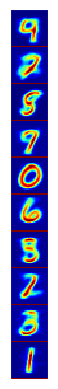

In [183]:
print(type(kmeans.cluster_centers_.T))
print(kmeans.cluster_centers_.T.shape)
A = display_network(kmeans.cluster_centers_.T, K, 1)
f1 = plt.imshow(A, interpolation='nearest', cmap = "jet")
f1.axes.get_xaxis().set_visible(False)
f1.axes.get_yaxis().set_visible(False)
plt.show()
# plt.savefig('a1.png', bbox_inches='tight')
# a colormap and a normalization instance
cmap = plt.cm.jet
norm = plt.Normalize(vmin=A.min(), vmax=A.max())
# map the normalized data to colors
# image is now RGBA (512x512x4)
image = cmap(norm(A))
import matplotlib.pyplot as plt

plt.imsave('aa.png', image)

In [184]:
N0 = 20;
X1 = np.zeros((N0*K, 784))
X2 = np.zeros((N0*K, 784))
for k in range(K):
    Xk = X0[pred_label == k, :]
    center_k = [kmeans.cluster_centers_[k]]
    neigh = NearestNeighbors(n_neighbors=N0).fit(Xk)
    dist, nearest_id = neigh.kneighbors(center_k, N0)
    X1[N0*k: N0*k + N0,:] = Xk[nearest_id, :]
    X2[N0*k: N0*k + N0,:] = Xk[:N0, :]

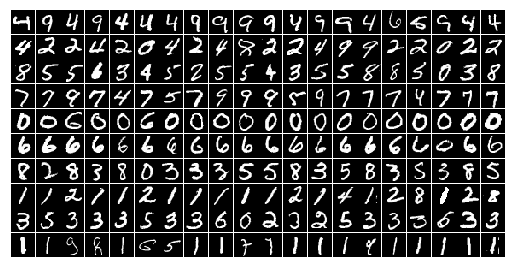

In [185]:
plt.axis('off')
A = display_network(X2.T, K, N0)
f2 = plt.imshow(A, interpolation='nearest' )
plt.gray()
plt.show()

### Bài 1.2. Áp dụng mô hình trên cho bài tập phân loại ảnh chó-mèo (xem lại phần CNN), thử thực hiện phân cụm thành 02 cụm và kiểm tra kết quả.

Contents of base directory: ['vectorize.py', 'train', 'validation']
Total training cat images: 1000
Total training dog images: 1000
Kích thước tập ảnh: (1000, 12288)


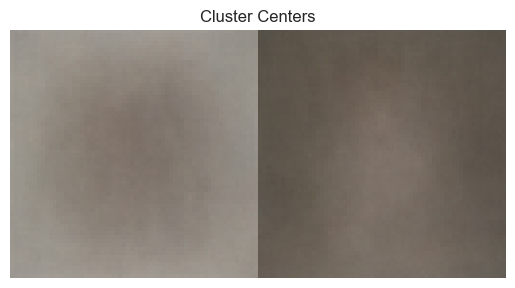

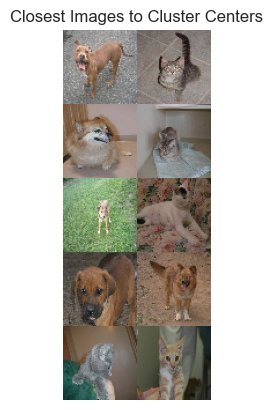

Adjusted Rand Index: 0.0011210205480955053
Cluster composition: [[221. 244.]
 [279. 256.]]
Accuracy: 0.523
Confusion matrix:
[[279 221]
 [256 244]]


In [186]:
import warnings
warnings.filterwarnings('ignore')

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import imageio

# 1) CẤU HÌNH ĐƯỜNG DẪN CHO PYCHARM

project_dir = '/Users/nguyencongtri/PycharmProjects/MachineLearning/Lab10'

local_zip = os.path.join(project_dir, 'cats_and_dogs_filtered (1).zip')
base_dir = os.path.join(project_dir, 'cats_and_dogs_filtered')

# Giải nén ZIP nếu chưa có folder
if not os.path.exists(base_dir):
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall(project_dir)
    zip_ref.close()


# 2) ĐỊNH NGHĨA THƯ MỤC ẢNH

train_dir = os.path.join(base_dir, 'train')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

print("Contents of base directory:", os.listdir(base_dir))
print("Total training cat images:", len(os.listdir(train_cats_dir)))
print("Total training dog images:", len(os.listdir(train_dogs_dir)))

# 3) HÀM LOAD ẢNH
def load_cats_dogs_data(num_images, image_size=64):
    train_cat_fnames = os.listdir(train_cats_dir)
    train_dog_fnames = os.listdir(train_dogs_dir)

    num_per_class = num_images // 2
    cat_fnames = np.random.choice(train_cat_fnames, num_per_class, replace=False)
    dog_fnames = np.random.choice(train_dog_fnames, num_per_class, replace=False)

    images, labels = [], []

    for fname in cat_fnames:
        img_path = os.path.join(train_cats_dir, fname)
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img).astype(np.float32) / 255.0
        images.append(img_array.flatten())
        labels.append(0)

    for fname in dog_fnames:
        img_path = os.path.join(train_dogs_dir, fname)
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img).astype(np.float32) / 255.0
        images.append(img_array.flatten())
        labels.append(1)

    return np.array(images), np.array(labels)

# 4) HÀM HIỂN THỊ ẢNH

def display_network(images, n_cols, n_rows, image_size=64, channels=3):
    images = images.T.reshape(-1, image_size, image_size, channels)
    A = np.zeros((n_rows * image_size, n_cols * image_size, channels))
    for i in range(n_rows):
        for j in range(n_cols):
            idx = i * n_cols + j
            if idx < images.shape[0]:
                A[i * image_size:(i + 1) * image_size,
                  j * image_size:(j + 1) * image_size, :] = images[idx]
    return A

# 5) LOAD DỮ LIỆU

num_images = 1000
image_size = 64
X, y = load_cats_dogs_data(num_images=num_images, image_size=image_size)
print("Kích thước tập ảnh:", X.shape)

# 6) KMEANS CLUSTERING
K = 2
kmeans = KMeans(n_clusters=K, random_state=42)
kmeans.fit(X)
pred_clusters = kmeans.labels_

# 7) HIỂN THỊ TRUNG TÂM CLUSTER
A = display_network(kmeans.cluster_centers_.T, K, 1, image_size=image_size, channels=3)
plt.imshow(A)
plt.axis("off")
plt.title("Cluster Centers")
plt.show()
imageio.imwrite("cluster_centers.png", (A * 255).astype(np.uint8))


# 8) ẢNH GẦN TRUNG TÂM CLUSTER
N0 = 5
X2 = np.zeros((N0 * K, image_size * image_size * 3))

for k in range(K):
    cluster_data = X[pred_clusters == k]
    if len(cluster_data) == 0:
        continue
    neigh = NearestNeighbors(n_neighbors=min(N0, len(cluster_data)))
    neigh.fit(cluster_data)

    center = kmeans.cluster_centers_[k].reshape(1, -1)
    dist, nearest = neigh.kneighbors(center)

    X2[N0*k:N0*k + len(nearest.flatten()), :] = cluster_data[nearest.flatten()]

A = display_network(X2.T, K, N0, image_size=image_size, channels=3)
plt.imshow(A)
plt.axis("off")
plt.title("Closest Images to Cluster Centers")
plt.show()
imageio.imwrite("cluster_images.png", (A * 255).astype(np.uint8))


# 9) ĐÁNH GIÁ CLUSTER

from sklearn.metrics import adjusted_rand_score, confusion_matrix

ari = adjusted_rand_score(y, pred_clusters)
print("Adjusted Rand Index:", ari)

cluster_counts = np.zeros((K, 2))
for k in range(K):
    cluster_labels = y[pred_clusters == k]
    cluster_counts[k] = [np.sum(cluster_labels == 0), np.sum(cluster_labels == 1)]

print("Cluster composition:", cluster_counts)

cluster_to_class = np.argmax(cluster_counts, axis=1)
mapped_labels = np.array([cluster_to_class[c] for c in pred_clusters])

accuracy = np.mean(mapped_labels == y)
print("Accuracy:", accuracy)

cm = confusion_matrix(y, mapped_labels)
print("Confusion matrix:")
print(cm)


# 2. PHẦN MÔ HÌNH DBSCAN

VÍ DỤ 2.1

In [187]:
class DBSCAN(object):
    def __init__(self,x,epsilon,minpts):
        # The number of input dataset
        self.n = len(x)
        # Euclidean distance
        p, q = np.meshgrid(np.arange(self.n), np.arange(self.n))
        self.dist = np.sqrt(np.sum(((x[p] - x[q])**2),2))
        # label as visited points and noise
        self.visited = np.full((self.n), False)
        self.noise = np.full((self.n),False)
        # DBSCAN Parameters
        self.epsilon = epsilon
        self.minpts = minpts
        # Cluseter
        self.idx = np.full((self.n),0)
        self.C = 0
        self.input = x

In [188]:
def regionQuery(self, i):
    g = self.dist[i,:] < self.epsilon
    Neighbors = np.where(g)[0].tolist()
    return Neighbors

In [189]:
def expandCluster(self, i):
    self.idx[i] = self.C
    k = 0
    while True:
        if len(self.neighbors) <= k:return
        j = self.neighbors[k]
        if self.visited[j] != True:
            self.visited[j] = True
            self.neighbors2 = self.regionQuery(j)
            v = [self.neighbors2[i] for i in np.where(self.idx[self.neighbors2]==0)[0]]

            if len(self.neighbors2) >= self.minpts:
                self.neighbors = self.neighbors+v
        if self.idx[j] == 0 : self.idx[j] = self.C
        k += 1

### Bài tập tự thực hành.

#### Bài tập 2.1. Thực hiện phân cụm bằng phương pháp K-means với dữ liệu tạo ra trong Ví dụ 2.1.

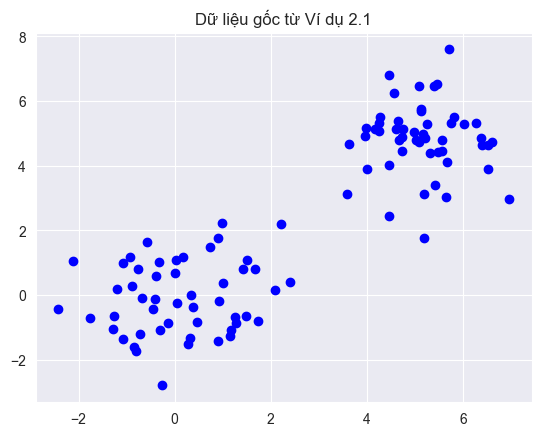

In [190]:
import numpy as np
import matplotlib.pyplot as plt
# Tạo dữ liệu ví dụ
np.random.seed(123)
# Cụm 1
x1 = np.random.randn(50, 2) + np.array([0, 0])
# Cụm 2
x2 = np.random.randn(50, 2) + np.array([5, 5])
# Gộp thành dataset X
X = np.vstack([x1, x2])
# Vẽ dữ liệu gốc
plt.scatter(X[:, 0], X[:, 1], color='blue')
plt.title("Dữ liệu gốc từ Ví dụ 2.1")
plt.show()


##### Phân cụm bằng K-means

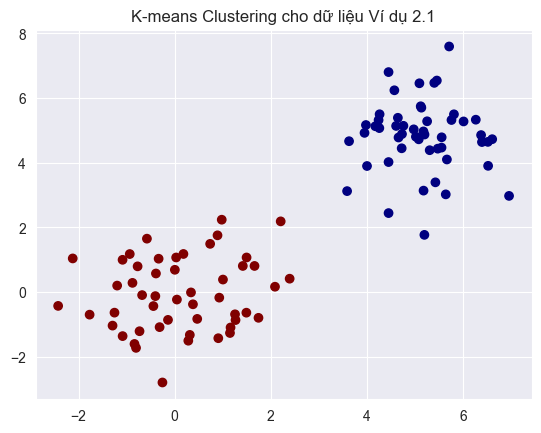

In [191]:
from sklearn.cluster import KMeans

# Phân cụm thành 2 cụm
kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(X)

# Vẽ kết quả
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='jet')
plt.title("K-means Clustering cho dữ liệu Ví dụ 2.1")
plt.show()


#### Bài tập 2.2

Số cột tuần: 52
Tên cột tuần: ['W0', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9'] ...
X shape: (811, 52)
X_scaled shape: (811, 52)


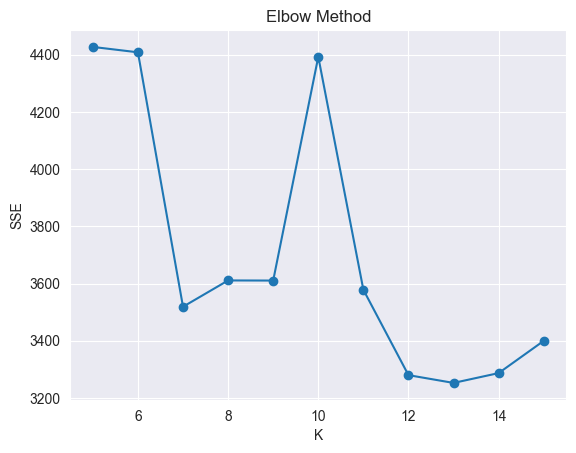

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("/Users/nguyencongtri/PycharmProjects/MachineLearning/Lab10/Sales_Transactions_Dataset_Weekly.csv")
# 2. LẤY CÁC CỘT TUẦN (W0–W51)
week_cols = [c for c in df.columns if c.startswith("W") and c[1:].isdigit()]
print("Số cột tuần:", len(week_cols))
print("Tên cột tuần:", week_cols[:10], "...")

X = df[week_cols].values
print("X shape:", X.shape)
# 3. CHUẨN HÓA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("X_scaled shape:", X_scaled.shape)

# 4. KMEANS TÌM ELBOW
# Hàm kmeans từ ví dụ của bạn
def kmeans(X, K, max_iters=100):
    # Chọn K tâm ngẫu nhiên
    indices = np.random.choice(X.shape[0], K, replace=False)
    centers = X[indices]

    for it in range(max_iters):
        # Gán nhãn
        dist = np.linalg.norm(X[:, None] - centers[None, :], axis=2)
        labels = np.argmin(dist, axis=1)

        # Tính tâm mới
        new_centers = np.array([X[labels == k].mean(axis=0) for k in range(K)])

        # Dừng nếu hội tụ
        if np.allclose(new_centers, centers):
            break

        centers = new_centers

    return centers, labels, it

# Tìm số cụm từ K=5 đến 15
Ks = range(5, 16)
SSE = []

for K in Ks:
    centers, labels, it = kmeans(X_scaled, K)
    sse = np.sum((X_scaled - centers[labels])**2)
    SSE.append(sse)
# 5. VẼ ELBOW
plt.plot(Ks, SSE, 'o-')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.grid(True)
plt.show()
